<a href="https://colab.research.google.com/github/ZamantaEst/Pruebas-Saber-Pro-Colombia-Kaggle/blob/main/04_modelo_con_preprocesado_y_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Modelo Random Forest
## Coneccion con kaggle

In [2]:
from google.colab import files
files.upload()   # Subir kaggle.json

import os
os.environ["KAGGLE_CONFIG_DIR"] = "."
!chmod 600 kaggle.json
!kaggle competitions download -c udea-ai-4-eng-20252-pruebas-saber-pro-colombia
!unzip udea*.zip > /dev/null

Saving kaggle.json to kaggle.json
  0% 0.00/29.9M [00:00<?, ?B/s]
100% 29.9M/29.9M [00:00<00:00, 1.38GB/s]


## Librerias

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#Organización de los datos

In [4]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

y = train["RENDIMIENTO_GLOBAL"]
X = train.drop(columns=["RENDIMIENTO_GLOBAL"])
test_id = test["ID"]

#Preprocesamiento

In [5]:
numeric_cols = ["INDICADOR_1","INDICADOR_2","INDICADOR_3","INDICADOR_4"]
categorical_cols = [c for c in X.columns if c not in numeric_cols and c != "ID"]

# imputación numérica con al mediana
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())
test[numeric_cols] = test[numeric_cols].fillna(X[numeric_cols].median())

# imputación categórica con dato missing
X[categorical_cols] = X[categorical_cols].fillna("MISSING")
test[categorical_cols] = test[categorical_cols].fillna("MISSING")

# Label Encoder
label_encoders = {}

for col in categorical_cols:
    X[col] = X[col].astype(str)
    test[col] = test[col].astype(str)

    le = LabelEncoder()
    le.fit(X[col])

    if "MISSING" not in le.classes_:
        le.classes_ = np.append(le.classes_, "MISSING")

    mask_new = ~np.isin(test[col], le.classes_)
    test[col] = np.where(mask_new, "MISSING", test[col])

    X[col] = le.transform(X[col])
    test[col] = le.transform(test[col])

    label_encoders[col] = le

#Entrenamiento RandomForestClassifier

In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y)

#Se definen los parametros para que tenga un buen rendimiento pero no tome mucho tiempo corriendo, esto se hizo a prueba y error
model = RandomForestClassifier(
    n_estimators=60,
    max_depth=12,
    min_samples_split=20,
    min_samples_leaf=10,
    n_jobs=-1,
    random_state=42)

print("Entrenando RandomForest...")
model.fit(X_train, y_train)

Entrenando RandomForest...


RandomForestClassifier(max_depth=12, min_samples_leaf=10, min_samples_split=20,
                       n_estimators=60, n_jobs=-1, random_state=42)

#Metricas


ACCURACY: 0.40584837545126357

Classification Report:
               precision    recall  f1-score   support

        alto       0.49      0.62      0.55     35124
        bajo       0.42      0.54      0.48     34597
  medio-alto       0.31      0.20      0.24     34324
  medio-bajo       0.32      0.26      0.28     34455

    accuracy                           0.41    138500
   macro avg       0.39      0.40      0.39    138500
weighted avg       0.39      0.41      0.39    138500



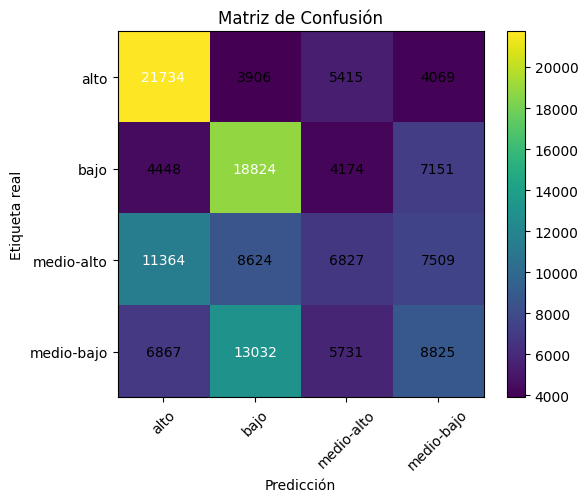

In [10]:
pred_val = model.predict(X_val)

print("\n==============================")
print("ACCURACY:", accuracy_score(y_val, pred_val))
print("==============================")

print("\nClassification Report:\n", classification_report(y_val, pred_val))
cm = confusion_matrix(y_val, pred_val)

#Matriz de confusión
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest')
plt.title("Matriz de Confusión")
plt.colorbar()

classes = np.unique(y_val)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel("Etiqueta real")
plt.xlabel("Predicción")
plt.tight_layout()
plt.show()


#Entrenamiento final para generar entregable de kaggle

In [11]:
print("\nEntrenando RandomForest FINAL con TODOS los datos...")

final_model = RandomForestClassifier(
    n_estimators=60,
    max_depth=12,
    min_samples_split=20,
    min_samples_leaf=10,
    n_jobs=-1,
    random_state=42)

final_model.fit(X, y)

pred = final_model.predict(test)

submission = pd.DataFrame({
    "ID": test_id,
    "RENDIMIENTO_GLOBAL": pred})

submission.to_csv("submission_randomforest.csv", index=False)

print("\nArchivo submission_randomforest.csv creado")



Entrenando RandomForest FINAL con TODOS los datos...

Archivo submission_randomforest.csv creado
